# Setup

## Imports

In [1]:
import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using Revise
using Dates

using LinearAlgebra

using Symbolics

import NonlinearSolve as NLS

In [2]:
import SuperconductingCavities as SC

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Some Extra Stuff

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Testing SNAIL!

In [58]:
Eʲ = 90
Eᶜ = 0.177
Eˡ = 64
α = 0.147
Φᵉ = 0.35
snail = SC.Hilbertspaces.Elements.SNAILs.init(Eᶜ, Eʲ, Eˡ, α, Φᵉ, 5, 5, name = "SNAIL");

In [59]:
snail.eigsys.values

5-element Vector{ComplexF64}:
 -0.03583361627070817 + 0.0im
    4.987592182928561 + 0.0im
    9.931761223200306 + 0.0im
   15.423973518113291 + 0.0im
     20.9679887111918 + 0.0im

In [60]:
Model = SC.Circuits.SNAIL_Resonators.init(Eᶜ, Eʲ, Eˡ, α, Φᵉ, [3, 7], [0.0756, 0.1349], 5, [5,5], Nₛ_full = 5);

In [62]:
println(Model.dressed_energies[(1,0,0)])
println(Model.dressed_energies[(0,1,0)])
println(Model.dressed_energies[(0,0,1)])

4.977243895648605
2.9585823982010417
6.9692782565003695


[2024-10-07 20:53:05] Info: Beginning Floquet Sweep
[2024-10-07 20:53:26] Info: Done With Floquet Sweep
[2024-10-07 20:53:26] Info: Tracking State "ψ2"
[2024-10-07 20:53:26] Info: Tracking State "ψ1"
[2024-10-07 20:53:26] Info: Fit Stuff: 3-element Vector{Float64}:	 -2.875531789774132e-5	  0.00038341386310459423	  2.000171082329589


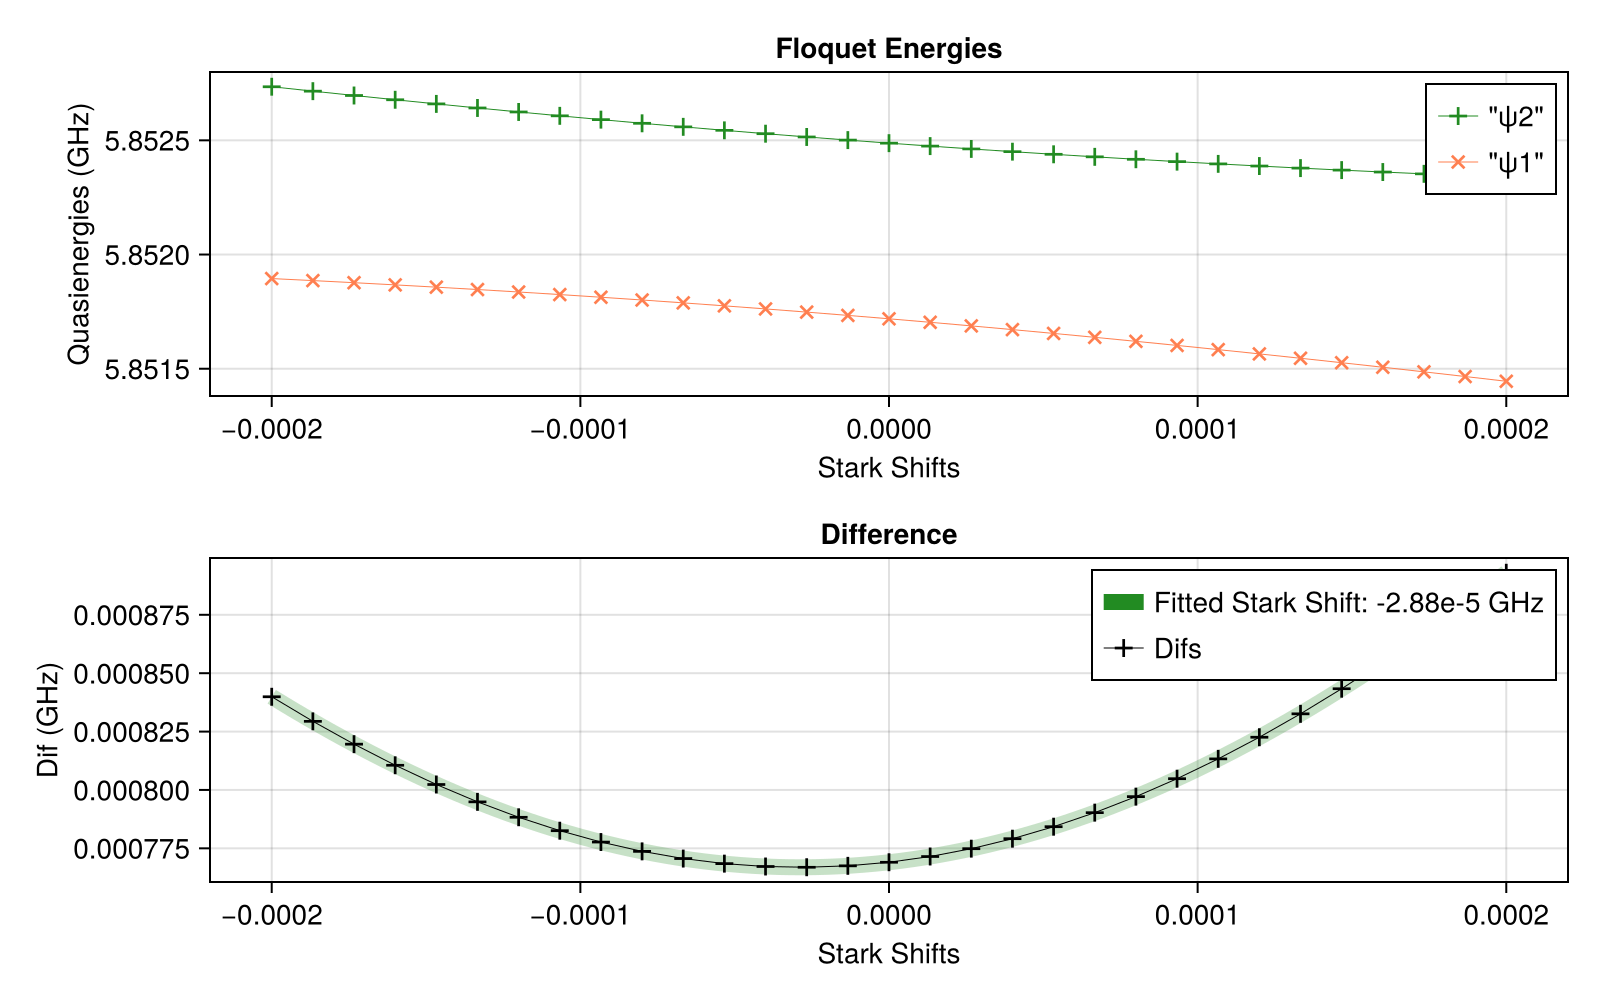

2-element Vector{Float64}:
   -2.875531789774132e-5
 1303.9623268383186

In [64]:
state1 = (0,1,0)
state2 = (0,0,1)

ε = 0.35

ψ1 = Model.dressed_states[state1]
ψ2 = Model.dressed_states[state2]

ν = Model.dressed_energies[state2]-Model.dressed_energies[state1]

drive_op = Model.n̂ₛ
starkshift_list = collect(LinRange(-2e-4, 2e-4, 31))

SC.Dynamics.FindStarkShift(Model.hilbertspace, drive_op, ψ1, ψ2, ν, ε, starkshift_list)



In [71]:
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" => 10, "pulse_time"=>0)

t_range = [1300, 1325]
sf = -2.875531789774132e-5

pulse_deets = SC.Dynamics.OptimizePulse(Model.Ĥ, drive_op, ψ1, ψ2, ε, ν, sf, t_range, envelope, envelope_args, levels = 2)

[2024-10-07 22:21:36] Info: On Level 1
[2024-10-07 22:21:36] Info: On Step 1: t = 1300.0
[2024-10-07 22:21:36] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 19s (ETA: 0h 00m 00s)
[2024-10-07 22:21:56] Info: Time Evolution Complete
[2024-10-07 22:21:56] Info: Done with Level_1_step_1
[2024-10-07 22:21:56] Info: Accurace: 0.9997001787469364
[2024-10-07 22:21:56] Info: ------------------------------------------------------------------------------
[2024-10-07 22:21:56] Info: On Step 2: t = 1306.25
[2024-10-07 22:21:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 29s (ETA: 0h 00m 00s)
[2024-10-07 22:22:26] Info: Time Evolution Complete
[2024-10-07 22:22:26] Info: Done with Level_1_step_2
[2024-10-07 22:22:26] Info: Accurace: 0.9999011151100292
[2024-10-07 22:22:26] Info: ------------------------------------------------------------------------------
[2024-10-07 22:22:26] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1312.5
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1312.5, "ramp_time"=>10)
  "epsilon"       => 0.35
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => -2.87553e-5
  "accuracy"      => 0.999984
  "freq_d"        => 4.0107

In [72]:
run_res = SC.Dynamics.RunSingleOperator(Model.Ĥ, drive_op, ψ1, pulse_deets)

[2024-10-07 22:25:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 18s (ETA: 0h 00m 00s)
[2024-10-07 22:26:14] Info: Time Evolution Complete
[2024-10-07 22:26:14] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 6564
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [75]:
proj_dict = SC.Utils.Get_Projection_Ops(Model.dressed_states)

evs = SC.Utils.Get_EVs(run_res.states, proj_dict);

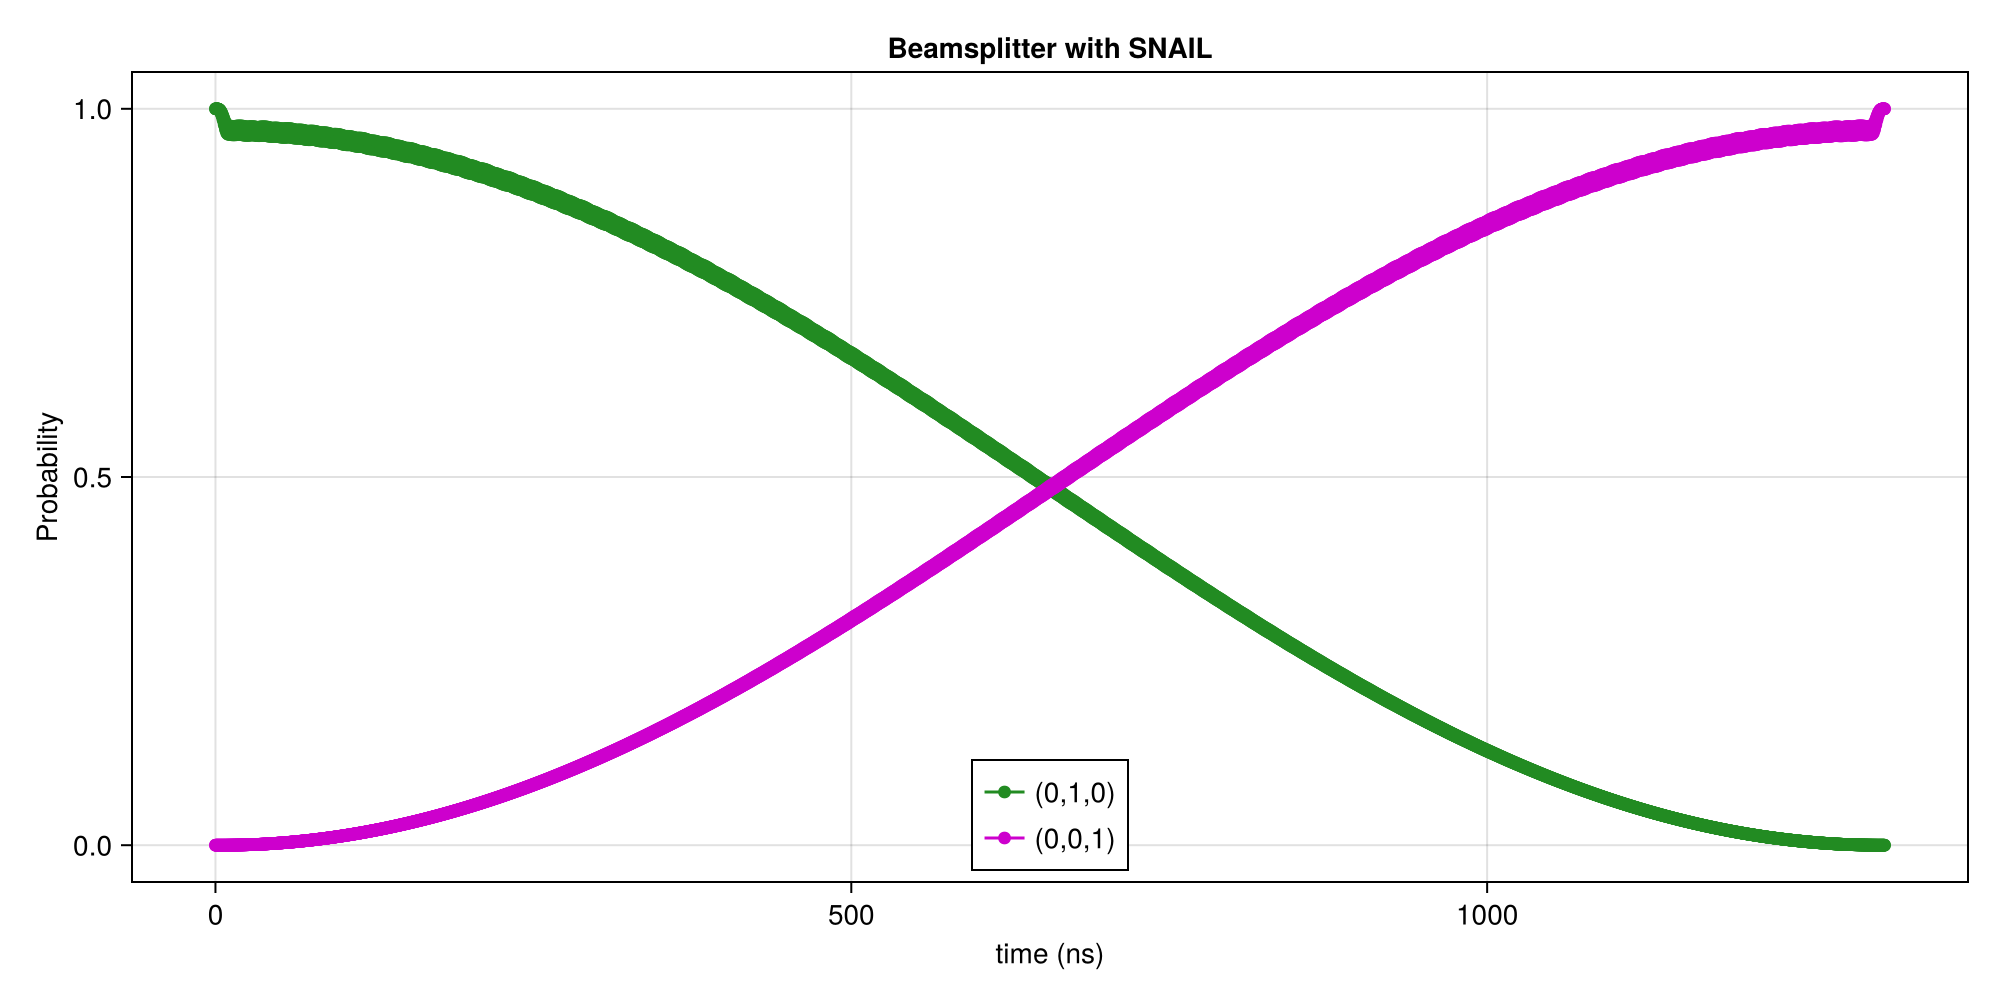

In [76]:
f = cm.Figure(size = (1000, 500))
ax = cm.Axis(f[1,1], title = "Beamsplitter with SNAIL", xlabel = "time (ns)", ylabel = "Probability")

cm.scatterlines!(ax, run_res.times, real.(evs[(0,1,0)]), label = "(0,1,0)", color =:forestgreen)
cm.scatterlines!(ax, run_res.times, real.(evs[(0,0,1)]), label = "(0,0,1)", color = :magenta3)

cm.axislegend(position = :cb)
f

In [29]:
run_res.times

925-element Vector{Float64}:
   0.0
   0.19987824675324675
   0.3997564935064935
   0.5996347402597403
   0.799512987012987
   0.9993912337662337
   1.1992694805194806
   1.3991477272727273
   1.599025974025974
   1.7989042207792207
   ⋮
 183.08847402597402
 183.28835227272728
 183.48823051948054
 183.68810876623377
 183.88798701298703
 184.08786525974025
 184.2877435064935
 184.48762175324674
 184.6875